# Background



In [7]:
import bayesld
import tempfile, subprocess
import pandas as pd
import multiprocess as mp
import msprime
import numpy as np

def simulate_and_process(seed):
    """Simulate ancestry + mutations and compute LD for a given seed."""
    theta = 1_000
    growth_rate = -0.02
    # Very high sample size
    n_samples = 20
    RECOMBINATION_RATE = 1e-8
    MUTATION_RATE = 1e-8
    CONTIG_LENGTH = 1e8

    # Simulate ancestry
    demography = msprime.Demography()
    demography.add_population(name="p0", initial_size=theta, growth_rate=growth_rate)
    demography.add_population_parameters_change(population="p0", time=100, initial_size=theta*np.exp(-growth_rate*100), growth_rate=0.0)
    ts = msprime.sim_ancestry(
        samples={"p0": n_samples},
        recombination_rate=RECOMBINATION_RATE,
        sequence_length=CONTIG_LENGTH,
        random_seed=seed,
        demography=demography
    )

    # Add mutations
    mts = msprime.sim_mutations(ts, rate=MUTATION_RATE, random_seed=seed)

    # Compute LD (inside a temporary directory)
    with tempfile.TemporaryDirectory() as tmpdir:
        trees_path = f"{tmpdir}/example.trees"
        bcf_path = f"{tmpdir}/example.bcf"

        mts.dump(trees_path)
        subprocess.run(
            f"tskit vcf --allow-position-zero {trees_path} | bcftools view -O b > {bcf_path}",
            shell=True,
            check=True
        )
        subprocess.run(["bcftools", "index", bcf_path], check=True)

        mean, variance, n, left, right = bayesld.compute_ld(bcf_path, "1", RECOMBINATION_RATE)

    return pd.DataFrame({
        'mean': mean,
        'variance': variance,
        'n': n,
        'left': left / 100,
        'right': right / 100,
        'seed': seed
    })


seeds = list(range(1, 10))  # run 10 replicates in parallel

# Parallel simulation + processing
with mp.Pool(processes=mp.cpu_count()) as pool:
    results = pool.map(simulate_and_process, seeds)

df = pd.concat(results)
data = df.pivot(index='seed', columns='left', values='mean').to_numpy()

In [16]:
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as pt
import bayesld.models

# Standardize data
empirical_sigma = data.std(ddof=1, axis=0)
left, right = df.left.unique(), df.right.unique()
n_contigs, n_bins = data.shape
n_samples = 20
coords = {
    'contig': np.arange(n_contigs),
    'bins': np.arange(n_bins)
}

with pm.Model(coords=coords) as model:
    # Effective population size
    Ne = pm.TruncatedNormal("Ne", 5_000, 500, lower=0)
    alpha = pm.Normal("alpha", 0, 0.01)
    t0 = pm.TruncatedNormal("t0", 100, 50, lower=0)
    Ne_a = Ne*np.exp(-alpha*t0)
    # Diagonal covariance: independent std for each bin

    # Expected LD (standardized)
    LD = pm.Deterministic(
        "LD",
        bayesld.models.expected_ld_exponential(Ne, Ne_a, t0, alpha, left, right, sample_size=n_samples),
        dims="bins"
    )

    # Observed data: MvNormal with diagonal covariance
    obs = pm.MvNormal(
        "obs",
        mu=LD,
        cov=pt.diag(empirical_sigma**2),  # diagonal covariance
        observed=data,
        dims=("contig", "bins")
    )

    trace = pm.sample(draws=10_000)

az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, alpha, t0]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.021,0.002,-0.025,-0.017,0.000,0.000,11004.0,11469.0,1.0
Ne,932.207,35.543,866.262,1000.080,0.324,0.217,11934.0,14025.0,1.0
t0,132.404,34.856,73.359,199.220,0.279,0.196,14416.0,14806.0,1.0
LD[0],0.020,0.000,0.019,0.020,0.000,0.000,26868.0,27424.0,1.0
LD[1],0.016,0.000,0.015,0.016,0.000,0.000,25674.0,24330.0,1.0
LD[2],0.013,0.000,0.013,0.014,0.000,0.000,30848.0,26753.0,1.0
LD[3],0.012,0.000,0.011,0.012,0.000,0.000,29694.0,28407.0,1.0
LD[4],0.010,0.000,0.010,0.011,0.000,0.000,24688.0,27318.0,1.0
LD[5],0.010,0.000,0.009,0.010,0.000,0.000,20849.0,25685.0,1.0
LD[6],0.009,0.000,0.009,0.009,0.000,0.000,18471.0,23355.0,1.0


array([[<Axes: title={'center': 'Ne'}>, <Axes: title={'center': 'Ne'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

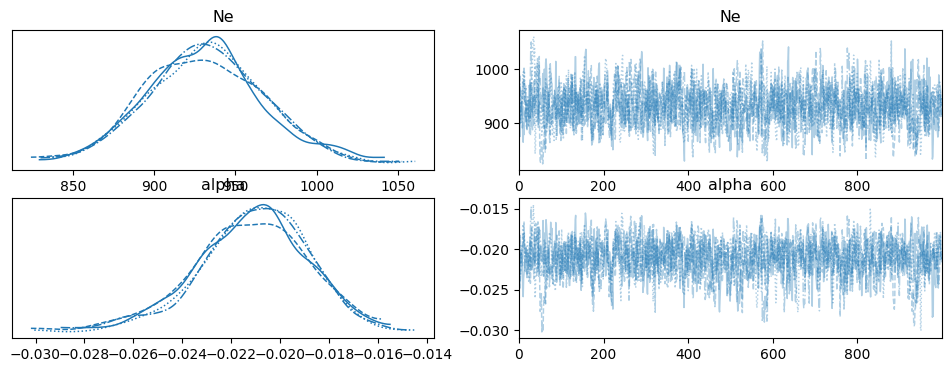

In [12]:
az.plot_trace(trace, var_names=['Ne', 'alpha'])

In [17]:
with model:
    pm.compute_log_likelihood(trace)
loo= az.loo(trace)
loo

Output()

Computed from 40000 posterior samples and 9 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   883.97    20.71
p_loo       14.43        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        9  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
with model.copy():
    LD_pp = pm.sample_posterior_predictive(trace)

Sampling: [obs]


Output()

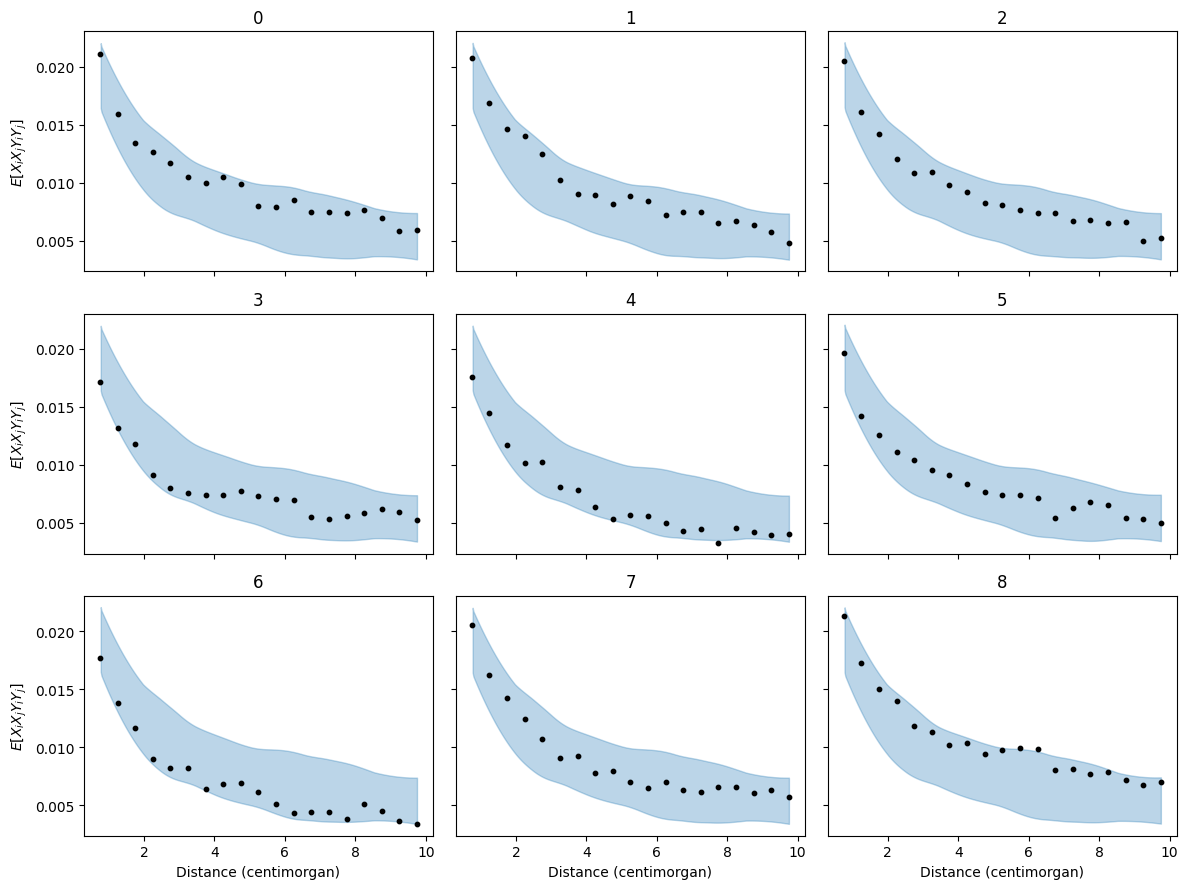

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

contigs = coords["contig"]
n_contigs = len(contigs)

# Layout: roughly square
ncols = int(np.ceil(np.sqrt(n_contigs)))
nrows = int(np.ceil(n_contigs / ncols))

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True
)
axes = axes.flatten()

x = (left+right) / 2 * 100

# HDI across chains/draws for each contig/bin
hdi_all = az.hdi(
    LD_pp.posterior_predictive["obs"], 
    input_core_dims=[["chain", "draw"]]
)

for i, contig in enumerate(contigs):
    ax = axes[i]

    # Select contig + variable → DataArray → numpy
    hdi_c = hdi_all["obs"].sel(contig=contig).to_numpy()

    az.plot_hdi(
        x,
        hdi_data=hdi_c,
        ax=ax,
        color="C0",
        fill_kwargs={"alpha": 0.3},
    )

    # Observed data
    y_obs = LD_pp.observed_data["obs"].sel(contig=contig).to_numpy()
    ax.scatter(x, y_obs, s=10, color="black")

    ax.set_title(str(contig))
    if i % ncols == 0:
        ax.set_ylabel(r"$E[X_i X_j Y_i Y_j]$")
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("Distance (centimorgan)")

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
